In [4]:
# Basics
import typing
import os
from pathlib import Path
import sys
import time
import numpy as np
import pandas as pd
import csv
from matplotlib import pyplot as plt
import arviz as az  # Visualization
import pytensor  # Graph-based tensor library
import hssm
hssm.set_floatX("float32")
from ssms.basic_simulators.simulator import simulator

# import ssms.basic_simulators # Model simulators
import hddm_wfpt
import bambi as bmb

# setting float precision in pytensor
pytensor.config.floatX = "float32"
import jax
jax.config.update("jax_enable_x64", False)

# check if GPU is available
import torch
if torch.cuda.is_available():
    print(f"Currently using: {torch.cuda.get_device_name(0)} device")
else:
    print("No GPU available, using CPU instead.")

AttributeError: partially initialized module 'jax' has no attribute 'version' (most likely due to a circular import)

In [5]:
from config import dir_config
compiled_dir = Path(dir_config.data.compiled)
processed_dir = Path(dir_config.data.processed)

In [6]:
import pickle
with open(Path(processed_dir, "glm_hmm_all_trials_prior_based_initialization_final.pkl"), "rb") as f:
	glm_hmm = pickle.load(f)

session_metadata = pd.read_csv(Path(compiled_dir, "sessions_metadata.csv"), index_col=None)

In [7]:
toRF_sessions = session_metadata["session_id"][session_metadata.prior_direction == "toRF"]
awayRF_sessions = session_metadata["session_id"][session_metadata.prior_direction == "awayRF"]

In [8]:
toRF_data = pd.DataFrame()
awayRF_data = pd.DataFrame()

for session in awayRF_sessions:
	session_data = glm_hmm['session_wise']['data'][session]
	session_data['subject_id'] = session.rsplit("_", 2)[-1]
	awayRF_data = pd.concat([awayRF_data, glm_hmm['session_wise']['data'][session]])

for session in toRF_sessions:
	session_data = glm_hmm['session_wise']['data'][session]
	session_data['subject_id'] = session.rsplit("_", 2)[-1]
	toRF_data = pd.concat([toRF_data, glm_hmm['session_wise']['data'][session]])


toRF_data = toRF_data[toRF_data['mask'] == 1]
toRF_data = toRF_data[~np.isnan(toRF_data['reaction_time'])]
toRF_data = toRF_data[['stimulus', 'choices', 'reaction_time', 'prob_toRF', 'subject_id']]
toRF_data['prob_toRF'] = toRF_data['prob_toRF'].apply(lambda x: 'equal' if x == 50.0 else 'unequal')
toRF_data['choices'] = toRF_data['choices'].apply(lambda x: 1 if x == 1 else -1)

awayRF_data = awayRF_data[awayRF_data['mask'] == 1]
awayRF_data = awayRF_data[~np.isnan(awayRF_data['reaction_time'])]
awayRF_data = awayRF_data[['stimulus', 'choices', 'reaction_time', 'prob_toRF', 'subject_id']]
awayRF_data['prob_toRF'] = awayRF_data['prob_toRF'].apply(lambda x: 'equal' if x == 50.0 else 'unequal')
awayRF_data['choices'] = awayRF_data['choices'].apply(lambda x: 1 if x == 1 else -1)

In [10]:
toRF_dataset = pd.DataFrame({
	'rt': toRF_data['reaction_time']/1000,
	'response': toRF_data['choices'],
	'stimulus': toRF_data['stimulus'],
	'prior_type': toRF_data['prob_toRF'],
	'subject_id': toRF_data['subject_id']
})

awayRF_dataset = pd.DataFrame({
	'rt': awayRF_data['reaction_time']/1000,
	'response': awayRF_data['choices'],
	'stimulus': awayRF_data['stimulus'],
	'prior_type': awayRF_data['prob_toRF'],
	'subject_id': awayRF_data['subject_id']
})


# save as pickle
data = {
	'toRF': toRF_dataset,
	'awayRF': awayRF_dataset
}

with open(Path(processed_dir, "ddm_data.pkl"), "wb") as f:
	pickle.dump(data, f)

No common intercept. Bounds for parameter v is not applied due to a current limitation of Bambi. This will change in the future.
No common intercept. Bounds for parameter v is not applied due to a current limitation of Bambi. This will change in the future.
No common intercept. Bounds for parameter a is not applied due to a current limitation of Bambi. This will change in the future.
No common intercept. Bounds for parameter a is not applied due to a current limitation of Bambi. This will change in the future.
Model initialized successfully.


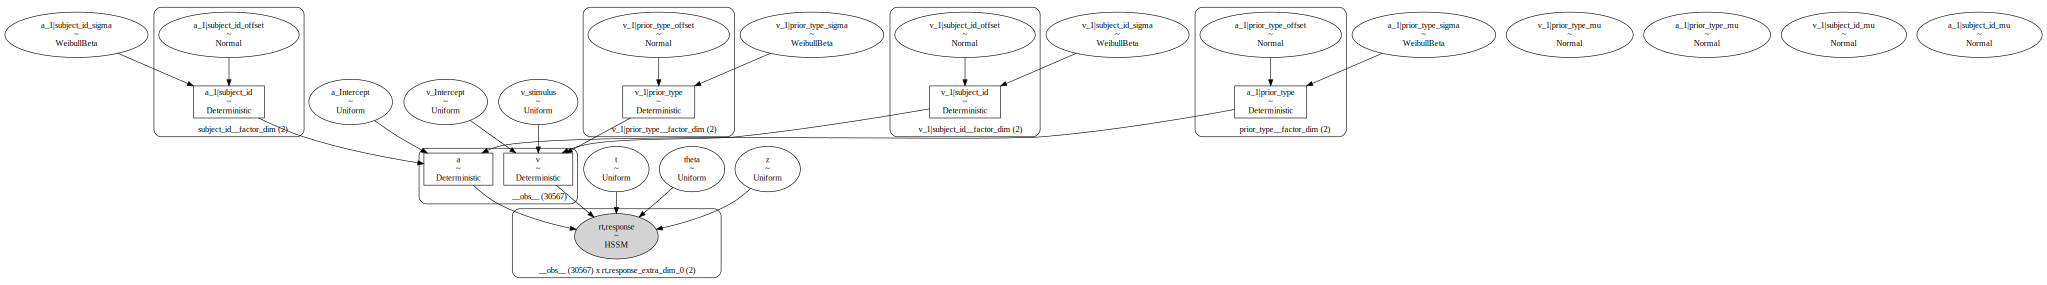

In [ ]:
toRF_model = hssm.HSSM(
    data=toRF_dataset,
    model="angle",
    include = [
        {
            "name": "v",
            "prior": {
                "Intercept": {"name": "Uniform", "lower": -3.0, "upper": 3.0},
                "stimulus":  {"name": "Uniform", "lower": -1.0, "upper": 1.0},
                "prior_type": {"name": "Uniform", "lower": -1.0, "upper": 1.0},
            },
            "formula": "v ~ (1|prior_type) + (1|subject_id) + stimulus",
            "link": "identity",

        },
        {
            "name": "a",
            "prior": {"Intercept": {"name": "Uniform", "lower": 0.5, "upper": 3.0},},
            "formula": "a ~ (1|prior_type) + (1|subject_id)",
        },

    ],
)

toRF_model.graph()


In [ ]:
idata_toRF_model = toRF_model.sample(
    sampler="nuts_numpyro", chains=2, cores=4, draws=500, tune=500
)

az.plot_posterior(pop_model_reg_v_a_subject.traces);

Using default initvals. 



E0407 00:36:17.377344   85550 cuda_dnn.cc:502] There was an error before creating cudnn handle (302): Error loading CUDA libraries. GPU will not be used. : Error loading CUDA libraries. GPU will not be used.
E0407 00:36:17.377798   85550 cuda_dnn.cc:502] There was an error before creating cudnn handle (302): Error loading CUDA libraries. GPU will not be used. : Error loading CUDA libraries. GPU will not be used.


XlaRuntimeError: FAILED_PRECONDITION: DNN library initialization failed. Look at the errors above for more details.